In [2]:
import torch
from torch.nn.functional import relu
import numpy as np
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [3]:
aug = MNISTAug()
dm = DataManager()
dm.load_test()

In [4]:
aug.min_objects = 1
aug.max_objects = 1

/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'class': 8,
 'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'x1': 22,
 'y1': 28,
 'x2': 56,
 'y2': 62,
 'cx': 39.0,
 'cy': 45.0,
 'height': 34,
 'width': 34}

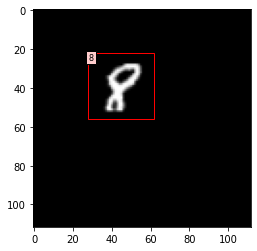

In [13]:
image, label = aug.get_augmented(dm.x_test, dm.y_test, 1)
image = image[0]
label = label[0][0]
DataManager.plot_num(image.reshape((112, 112)), [label])
label

In [21]:
op_w = 64
op_h = 64

in_w = 112
in_h = 112

In [22]:
def add_scalar_noise(value, scale=0.01):
    return value + (np.random.random((1,))[0] - 0.5) * scale

cx = add_scalar_noise(label['cx'] / in_w)
cy = add_scalar_noise(label['cy'] / in_h)
w = add_scalar_noise(label['width'] / in_w)
h = add_scalar_noise(label['height'] / in_h)
theta = [cx, cy, w, h]

In [23]:
region_w = w * in_w
region_h = h * in_h
region_x1 = (cx * in_w) - (region_w / 2)
region_y1 = (cy * in_h) - (region_h / 2)

step_w = region_w / op_w
step_h = region_h / op_h

# TODO: Parallelize this step
grid = np.zeros((op_w, op_h, 2))
for i in range(op_w):
    for j in range(op_h):
        grid[i][j][0] = i * step_w
        grid[i][j][1] = j * step_h

In [24]:
op = np.zeros((op_w, op_h))

def bilinear_kernel(d):
    return max(0, 1 - abs(d))

def get_op_pixel(i, j):
    for i_ in range(in_w):
        for j_ in range(in_h):
            image[i_][j_] * bilinear_kernel()

for i in range(op_w):
    for j in range(op_h):
        op[i][j] = get_op_pixel(i, j)

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.53330716],
        [ 0.        ,  1.06661433],
        ...,
        [ 0.        , 32.53173695],
        [ 0.        , 33.06504411],
        [ 0.        , 33.59835128]],

       [[ 0.52843927,  0.        ],
        [ 0.52843927,  0.53330716],
        [ 0.52843927,  1.06661433],
        ...,
        [ 0.52843927, 32.53173695],
        [ 0.52843927, 33.06504411],
        [ 0.52843927, 33.59835128]],

       [[ 1.05687853,  0.        ],
        [ 1.05687853,  0.53330716],
        [ 1.05687853,  1.06661433],
        ...,
        [ 1.05687853, 32.53173695],
        [ 1.05687853, 33.06504411],
        [ 1.05687853, 33.59835128]],

       ...,

       [[32.23479524,  0.        ],
        [32.23479524,  0.53330716],
        [32.23479524,  1.06661433],
        ...,
        [32.23479524, 32.53173695],
        [32.23479524, 33.06504411],
        [32.23479524, 33.59835128]],

       [[32.7632345 ,  0.        ],
        [32.7632345 ,  0.53